In [15]:
import cooler
import pandas as pd
import numpy as np
import scipy
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools

# Input data to run this notebook

In [3]:
# Merged Hi-C data
# Run 1_merge_Hi-C.sh script to obtain these maps
clr_neur_path = '../data/NeuNplus.sampled.1000.mcool::resolutions/250000'

# Middle values of neuronal dot anchor regions 
neuronal_dot_cent_path = '../data/neuronal_dot_anchors.centers.bed.gz'

# H3K9me3 data obtained from ENCODE database
h3k9me3_astro_path = '../data/ENCODE.H3K9me3.astro.bedgraph.gz'
h3k9me3_fetal_path = '../data/ENCODE.H3K9me3.fetal.bedgraph.gz'

# Average signal curve calculation and plotting (Figure 4G)

In [12]:
def pylap_new(path_to_points,path_to_data,nbins,chrs):
    Q=0
    points=pd.read_csv(path_to_points,sep='\t',header=None)
    chr_length={'chr1':248956422,'chr2':242193529,'chr3':198295559,'chr4':190214555,'chr5':181538259,'chr6':170805979,'chr7':159345973,'chr8':145138636,'chr9':138394717,
    'chr10':133797422,'chr11':135086622,'chr12':133275309,'chr13':114364328,'chr14':107043718,'chr15':101991189,'chr16':90338345,
    'chr17':83257441,'chr18':80373285,'chr19':58617616,'chr20':64444167,'chr21':46709983,'chr22':50818468,'chrX':156040895,'chrY':57227415,'chrM':16569}
    
    points.columns=['chrom','start','end']

    for i in list(chr_length.keys()):

        points=points.drop(points[(points['chrom']==i) & (points['start']>chr_length[i]-2500000)].index)

    h=points[points['start']>=3000000]

    h.sort_values(['chrom','start'],inplace=True)

    points=pybedtools.BedTool.from_dataframe(h)
    path=pd.read_csv(path_to_data,sep='\t',header=None)
    data=pybedtools.BedTool.from_dataframe(path)
    t=data.intersect(points,wao=True).to_dataframe()

    t= t.loc[t['chrom'].isin(chrs)]
    t.loc[t.name=='.','name']=np.nan
    q=sum(t['strand']!=-1)

    n=np.zeros((q,2*nbins+1))
    k=0
    for i in chrs:
       
        tmp=t[t['chrom']==i]
       
        tmp=tmp.reset_index(drop=True)
        for j in range(len(tmp)):

            if tmp.loc[j]['strand']!=-1:
                
                n[k]=tmp.loc[j-nbins:j+nbins]['name']

                k+=1
            
    A=pd.DataFrame(n)

    return(A)
    

In [13]:
def plott(xx,lab,m,cols):
    l=[]
    u=[]
    for i in xx.columns:
        a=xx[i]
        x,y=st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
        l.append(x)
        u.append(y)
    xfit = np.linspace(0,2*m, 100) 
    
    spl = scipy.interpolate.make_interp_spline(np.arange(2*m+1),np.mean(xx,axis=0), k=3)  # type: BSpline
    yfit = spl(xfit)
    spl = scipy.interpolate.make_interp_spline(np.arange(2*m+1),l, k=3)  # type: BSpline
    fit_l = spl(xfit)

    spl = scipy.interpolate.make_interp_spline(np.arange(2*m+1),u, k=3)  # type: BSpline
    fit_u = spl(xfit)

    plt.plot(xfit, yfit, '-',label=lab,c=cols)

    plt.fill_between(xfit, fit_l, fit_u,
                 color='gray', alpha=0.2)

In [ ]:
c=cooler.Cooler(clr_neur_path)
po1=pylap_new(neuronal_dot_cent_path,
              h3k9me3_astro_path,20,c.chromnames[0:-2])
po2=pylap_new(neuronal_dot_cent_path,
              h3k9me3_fetal_path,20,c.chromnames[0:-2])

Text(0.5, 0, 'distance from center of contact anchor, kb')

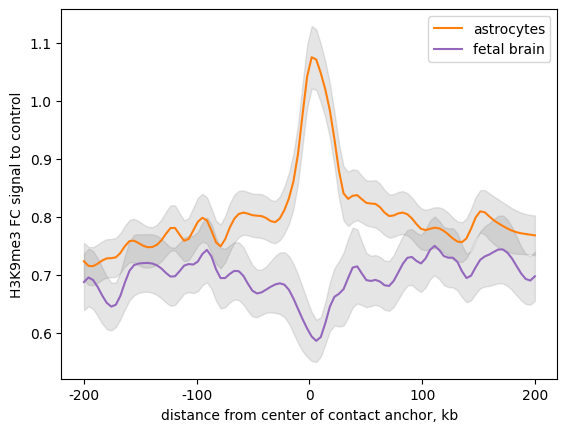

In [16]:
plott(po1,'astrocytes',20,sns.color_palette()[1])
plott(po2,'fetal brain',20,sns.color_palette()[4])

plt.ylabel('H3K9me3 FC signal to control')
plt.legend()
plt.xticks(np.arange(0,41,10),np.arange(-200,201,100))
plt.xlabel('distance from center of contact anchor, kb')